# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
# Import libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math
import json
import datetime
import locale
% matplotlib inline

# Import machine learning related libraries
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Review Data

### **Portfolio**
* **Offers sent during 30-day test period (10 offers x 6 fields)**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [2]:
# Read the portfolio samples
print("Portfolio has %d rows and %d columns."  %portfolio.shape)

portfolio.head()

Portfolio has 10 rows and 6 columns.


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
# Count the number of different offer type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

**There are 10 different offers.**
* BOGO has 4 different offers
* Discount has 2 different offers
* Informational has 2 different offers

### **Profile**
* **Rewards program users (17000 users x 5 fields)**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [4]:
# Read the profile samples
print("Profile has %d rows and %d columns."  %profile.shape)
profile.head()

Profile has 17000 rows and 5 columns.


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
# Check null values in dataset
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [6]:
# Identify customers at age 118 and null in gender are the same group of people.
null_gender = profile[profile['gender'].isnull()]
null_gender.age.value_counts()

118    2175
Name: age, dtype: int64

**Customers with age 118 also don't have value on gender and income and can be removed from the dataset.**

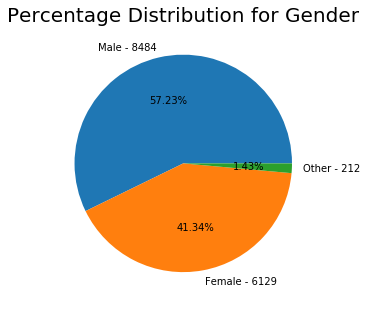

In [7]:
# Analyze the gender distribution for customers

# Counts the gender in Male, Female, and Others (excluding Null value)
value_counts = profile['gender'].value_counts().reset_index()
#print(value_counts) #Male - 8484, Female - 6129, Other - 212
#print(value_counts.sum()) # Total is 14825
plt.subplots(figsize=(5,5))
plt.title('Percentage Distribution for Gender',size = 20)
plt.pie(x=value_counts['gender'], labels= ['Male - 8484','Female - 6129','Other - 212'], autopct='%0.2f%%')

plt.show()

**There are total 14825 valid user in this dataset (Excluded 2175 customers whose ages at 118.)**
* Male - 8484 (57.23%)
* Female - 6129 (41.34%)
* Others - 212 (1.43%)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


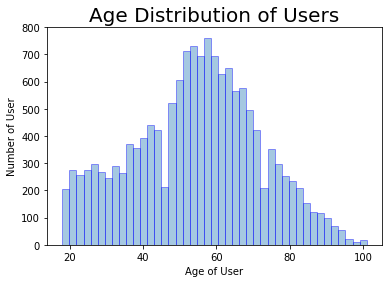

In [8]:
# Analyze the age distribution for customers
sorted_age = profile[profile.age < 118]
fig= plt.subplots(figsize=(6,4))
sns.distplot(sorted_age['age'], kde = False, hist_kws={'edgecolor':'blue'})
plt.title('Age Distribution of Users',size = 20)
plt.xlabel('Age of User', size =10)
plt.ylabel('Number of User', size =10)

plt.show()

**Most registered customers are from ages 50 to 70.**
* People between age 20-40 are not the largest group of customer.

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


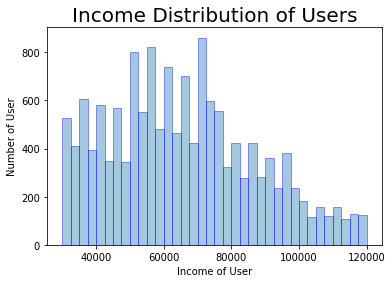

In [9]:
# Analyze the income distribution for customers
sorted_age = profile[profile.age < 118]
fig= plt.subplots(figsize=(6,4))
sns.distplot(sorted_age['income'], kde = False, hist_kws={'edgecolor':'blue'})
plt.title('Income Distribution of Users',size = 20)
plt.xlabel('Income of User', size =10)
plt.ylabel('Number of User', size =10)

plt.show()

**Most registered customers' income are between 50K to 75K**
* People earn more not necessary drinks more Starbucks.
* On the other hand, people earn less money also drinks a lot of Starbucks.

### **Transcript**
* **Event log (306648 events x 4 fields)**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record
    * offer id: (string/hash) not associated with any "transaction"
    * amount: (numeric) money spent in "transaction"
    * reward: (numeric) money gained from "offer completed"

In [10]:
# Read the transcript samples
print("Transcript has %d rows and %d columns."  %transcript.shape)
transcript.head()

Transcript has 306534 rows and 4 columns.


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
# Check any null event in the dataset
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

**There are no null event in this transcript, but the number of event is 306534 which is different than the one provide from Udacity classroom 306534.**

In [12]:
# Count each event number
transcript['event'].value_counts().reset_index()

,index,event
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


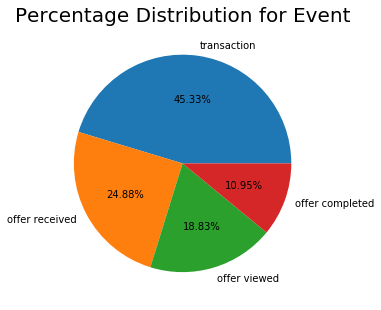

In [13]:
# Analyze the event percentage for transcript
value_counts = transcript['event'].value_counts().reset_index()
plt.subplots(figsize=(5,5))
plt.title('Percentage Distribution for Event',size = 20)
plt.pie(x=value_counts['event'], labels= value_counts['index'], autopct='%0.2f%%')
plt.show()

## Cleaning the dataset 

### First we will update the Transcript data 


In [14]:
# Rename the column 'person' into 'customer_id' to match all dataset
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

# Change the 'time' value from hour to day
transcript['time'] /= 24.0

# Create two different columns for the 'value' column
# 'offer id' and 'offer_id' should combine into one group and we create a column named 'offer_id'
# 'amount' contain a number that's different to offer_id so we create another column named 'amount'
    
transcript['offer_id'] = transcript.value.apply(lambda x: list(x.values())[0] if (list(x.keys())[0] in ['offer id', 'offer_id']) else np.NaN)
transcript['amount'] = transcript.value.apply(lambda x: list(x.values())[0] if (list(x.keys())[0]=='amount') else np.NaN)

# Drop the 'value' column to avoid duplication
transcript.drop(columns=['value'], inplace=True)

# Check and drop the duplicates values
print("There are %d duplicates values. Dropped successfully!"  %transcript.duplicated().sum())
transcript.drop_duplicates(inplace=True)

There are 397 duplicates values. Dropped successfully!


In [15]:
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### Then we update the Profile data

In [16]:
# Remove all the age 118 customers since they don't have gender and income as well
profile.drop(profile.loc[profile['age']==118].index, inplace=True)

# Change the date format into YYYY-MM-DD and split it into three columns as well
profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['member_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))

# Drop the 'became_member_on' column since we have updated version
profile.drop('became_member_on', axis=1, inplace=True)

# Change the column name of id to customer_id to avoid duplication
profile.rename(columns={'id': 'customer_id'}, inplace=True)

# Split gender into individual column
profile['male'] = profile.gender.apply(lambda x: 1 if x =='M' else 0)
profile['female'] = profile.gender.apply(lambda x: 1 if x =='F' else 0)
profile['others'] = profile.gender.apply(lambda x: 1 if x =='O' else 0)

In [17]:
profile.head()

,age,gender,customer_id,income,member_year,member_month,member_day,member_date,male,female,others
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,2017-07-15,0,1,0
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,2017-05-09,0,1,0
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,2018-04-26,1,0,0
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,2018-02-09,1,0,0
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,2017-11-11,1,0,0


### Finally we update the Portfolio data

In [18]:
# Rename column 'id' to 'offer_id' to make it more consistence
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

# Replace the channels column into each type of channel
channel_list = np.unique(portfolio['channels'])
for channel in channel_list[3]:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
portfolio.drop('channels', axis=1, inplace=True)

# Replace the offer_type column into each offer type 
for offer in portfolio.offer_type.unique():
    portfolio[offer] = portfolio['offer_type'].apply(lambda x: 1 if offer in x else 0)
portfolio.drop('offer_type', axis=1, inplace=True)

In [19]:
portfolio.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,informational,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,0,1


## Preprocessing the data

In [20]:
# Create a dataframe that only shows the transaction
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df.head()

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
12659,54890f68699049c2a04d415abc25e717,0.0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [21]:
# Create a dataframe that only shows the offer and without the transaction
offers_df = transcript[transcript.event!='transaction'].copy()

# Change the event into numerical format and create column for each of event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

# Drop columns 'event' and 'amount' for cleaner look
offers_df.drop(columns=['event', 'amount'], inplace=True)

In [22]:
offers_df.head()

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
2,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0


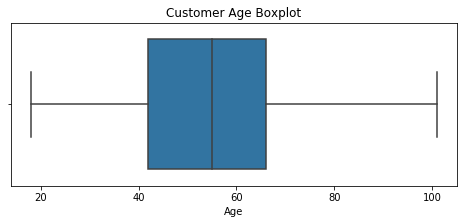

In [23]:
# Plot a boxplot to see the age distrubution
plt.figure(figsize=(8, 3))
sns.boxplot(profile['age'])
plt.title('Customer Age Boxplot')
plt.xlabel('Age')
plt.show();

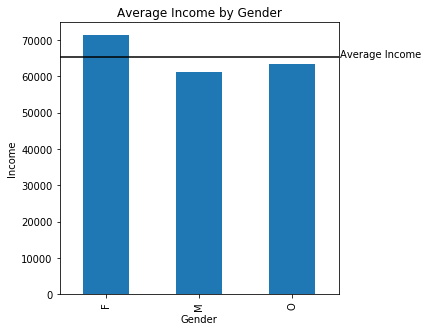

Average income is $65,404.99 in this dataset.


In [24]:
# Calculate the mean of this dataset and use it as a reference to plot a bar chart
mean_income = profile.income.mean()
income_by_gender = profile.groupby('gender', as_index=False).agg({'income':'mean'})
income_by_gender.plot(kind = 'bar', x = 'gender', y = 'income', legend=False, figsize=(5,5))
plt.hlines(mean_income, -1 , 3)
plt.ylabel('Income')
plt.xlabel('Gender')
plt.title('Average Income by Gender')
plt.text(2.52, mean_income, 'Average Income')
plt.show()

# Show the average income for this dataset
locale.setlocale( locale.LC_ALL, '' )
print ("Average income is %s in this dataset." %locale.currency(mean_income, grouping=True ))

# Drop gender column for better calculation
profile.drop('gender', axis=1, inplace=True)

## Modelling

### Combine all these preprocessing data into one big dataset

**Tips: This code block below takes about 10 minutes to run.**

In [25]:
# Initiate  a list to store the data. 
data = []

# Create a list of unique user id to iteration.
ids = offers_df['customer_id'].unique()

# Retrieve all the transaction and offer related details from the dataset for futhuer usage
for i in ids:
    customer_id = i
    customer = profile[profile['customer_id']==customer_id]
    customer_offer = offers_df[offers_df['customer_id']==customer_id]
    customer_transaction = transaction_df[transaction_df['customer_id']==customer_id]
    
    offer_received = customer_offer[customer_offer['received'] == 1]
    offer_completed = customer_offer[customer_offer['completed'] == 1]
    offer_viewed = customer_offer[customer_offer['viewed'] == 1]
    
    rows = []
    
    # Identify the is the offer successful and if there is transaction between the offer duration
    for i in range(offer_received.shape[0]):
        offer_id = offer_received.iloc[i]['offer_id']
        offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
        duration_time = offer_row['duration'].values[0]
        start_time = offer_received.iloc[i]['time']
        end_time = start_time + duration_time
        
        offer_completed_check = np.logical_and(offer_completed['time'] >= start_time, offer_completed['time'] <= end_time)
        offer_viewed_check = np.logical_and(offer_viewed['time'] >= start_time, offer_viewed['time'] <=end_time)
        offer_successful = offer_completed_check.sum() > 0 and offer_viewed_check.sum() > 0
        
        transaction_check = np.logical_and(customer_transaction['time'] >= start_time, customer_transaction['time'] <= end_time)
        transaction_data = customer_transaction[transaction_check]
        transaction_total_amount = transaction_data['amount'].sum()
        
        row = {
                'offer_id': offer_id,
                'customer_id': customer_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
        row.update(offer_row.iloc[0,0:].to_dict())
        rows.append(row)
    data.extend(rows)
    
# Creates dataframe for the data
data = pd.DataFrame(data)

In [26]:
# Merge the data to the profile to have a final dataset for 
final = data.merge(profile, how = 'inner', on = 'customer_id')
final.head()

,bogo,customer_id,difficulty,discount,duration,email,informational,mobile,offer_id,offer_successful,...,web,age,income,member_year,member_month,member_day,member_date,male,female,others
0,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,7,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,...,1,75,100000.0,2017,5,9,2017-05-09,0,1,0
1,0,78afa995795e4d85b5d9ceeca43f5fef,0,0,3,1,1,1,5a8bc65990b245e5a138643cd4eb9837,0,...,0,75,100000.0,2017,5,9,2017-05-09,0,1,0
2,1,78afa995795e4d85b5d9ceeca43f5fef,10,0,7,1,0,1,ae264e3637204a6fb9bb56bc8210ddfd,1,...,0,75,100000.0,2017,5,9,2017-05-09,0,1,0
3,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,5,1,0,1,f19421c1d4aa40978ebb69ca19b0e20d,1,...,1,75,100000.0,2017,5,9,2017-05-09,0,1,0
4,0,e2127556f4f64592b11af22de27a7932,10,1,7,1,0,1,2906b810c7d4411798c6938adc9daaa5,0,...,1,68,70000.0,2018,4,26,2018-04-26,1,0,0


In [27]:
# Print all the columns header from the final dataset
list(final)

['bogo',
 'customer_id',
 'difficulty',
 'discount',
 'duration',
 'email',
 'informational',
 'mobile',
 'offer_id',
 'offer_successful',
 'reward',
 'social',
 'time',
 'total_amount',
 'web',
 'age',
 'income',
 'member_year',
 'member_month',
 'member_day',
 'member_date',
 'male',
 'female',
 'others']

#### Because we want to focus on the demographic characteristic and the offer feature. So we will drop some of the column that might not help make this model more acurrate

In [28]:
# Drop some of the columns that might not needed for the Machine Learning
final.drop(columns=['customer_id','offer_id','member_day','member_month','member_date','member_year','email','social','web','mobile'], inplace=True)
final.head(1)

,bogo,difficulty,discount,duration,informational,offer_successful,reward,time,total_amount,age,income,male,female,others
0,1,5,0,7,0,1,5,0.0,37.67,75,100000.0,0,1,0


In [29]:
target = final['offer_successful']
features = final.drop(columns=['offer_successful'])

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features.astype(float)))
features_scaled.columns = features.columns
features_scaled.index = features.index

In [31]:
# Print it out to test it's working or not
features_scaled.head()

,bogo,difficulty,discount,duration,informational,reward,time,total_amount,age,income,male,female,others
0,1.0,0.25,0.0,0.571429,0.0,0.5,0.000000,0.031366,0.686747,0.777778,0.0,1.0,0.0
1,0.0,0.00,0.0,0.000000,1.0,0.0,0.291667,0.041124,0.686747,0.777778,0.0,1.0,0.0
2,1.0,0.50,0.0,0.571429,0.0,1.0,0.708333,0.040200,0.686747,0.777778,0.0,1.0,0.0
3,1.0,0.25,0.0,0.285714,0.0,0.5,0.875000,0.040200,0.686747,0.777778,0.0,1.0,0.0
4,0.0,0.50,1.0,0.571429,0.0,0.2,0.000000,0.000000,0.602410,0.444444,1.0,0.0,0.0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled.values, target.values, test_size=0.3, random_state=42)

In [33]:
X_train

array([[0.  , 0.5 , 1.  , ..., 0.  , 1.  , 0.  ],
       [0.  , 0.5 , 1.  , ..., 0.  , 1.  , 0.  ],
       [1.  , 0.25, 0.  , ..., 0.  , 1.  , 0.  ],
       ...,
       [0.  , 0.35, 1.  , ..., 1.  , 0.  , 0.  ],
       [0.  , 1.  , 1.  , ..., 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 0.  , 0.  ]])

In [34]:
# Rewrite out x_train and x_test because of there are itergers/floats in our columns
X_train = X_train[:, 2:].astype('float64')
X_test = X_test[:, 2:].astype('float64')

# Convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

# Print out the number of training set and testing set for reference
print("Training set has %d" %(X_train.shape[0]))
print("Testing set has %d" %(X_test.shape[0]))

Training set has 46550
Testing set has 19951


In [35]:
# Create global variables for cleaner code
f1_train = 'F1-score: training dataset'
acc_train = 'Accuracy: training dataset'
f1_test = 'F1-score: testing dataset'
acc_test = 'Accuracy: test dataset'

# Define train_predict and test_predict function to print out the result.
def train_predict(classifier, X_train, y_train):
    y_pred_train = classifier.predict(X_train)
    train_results = {}
    train_results[f1_train] = f1_score(y_train, y_pred_train)
    train_results[acc_train] = accuracy_score(y_train, y_pred_train)
    print (classifier.__class__.__name__)
    print(train_results)
    return train_results, y_pred_train

def test_predict(classifier, X_test, y_test):
    y_pred_test = classifier.predict(X_test)
    test_results = {}
    test_results[f1_test] = f1_score(y_test, y_pred_test) 
    test_results[acc_test] = accuracy_score(y_test, y_pred_test)
    print (classifier.__class__.__name__)
    print(test_results)
    return test_results, y_pred_test

### K- Neatest Neighbors

**Now let's test out the KNN method**

In [36]:
# Find the k value from 1 to 21
error = []

for i in range(1, 21):
    classifier = KNeighborsClassifier(n_neighbors=i)
    KNN_classifier = classifier.fit(X_train, y_train)
    pred_i = classifier.predict(X_test)
    error.append(np.mean(pred_i != y_test))

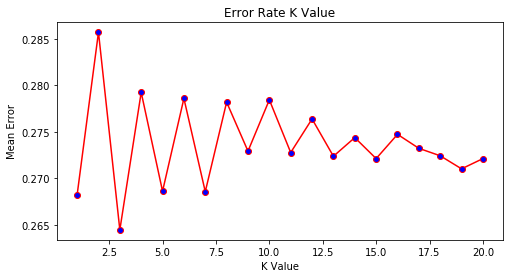

In [37]:
# Plot a line chart to shows the trending for the k value
plt.figure(figsize=(8, 4))
plt.plot(range(1, 21), error, color='red', marker='o',markerfacecolor='blue')
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

In [38]:
# Select the optimal k value and initiate KNeighborsClassifier
classifier_refined = KNeighborsClassifier(n_neighbors=3)

# Fit train data to the classifier
KNN_classifier = classifier_refined.fit(X_train, y_train)

In [39]:
# Print the result for KNeighborsClassifier
knn_output_train = train_predict(classifier, X_train, y_train)
knn_output_test = test_predict(classifier, X_test, y_test)

KNeighborsClassifier
{'F1-score: training dataset': 0.7431832593532023, 'Accuracy: training dataset': 0.7563909774436091}
KNeighborsClassifier
{'F1-score: testing dataset': 0.7121573617517628, 'Accuracy: test dataset': 0.727883314119593}


### Logistic Regression

**After getting the result from the benchmark(KNN method), let's check the logistic regression method. Let's start with the default setup first.**
- for small dataset liblinear is a better choice

In [40]:
# Initiate LogisticRegression
lr_clf = LogisticRegression(solver='liblinear')

# Fit train data to the classifier
LR_classifier = lr_clf.fit(X_train, y_train)

In [41]:
# Print the result for LogisticRegression
lr_output_train = train_predict(LR_classifier, X_train, y_train)
lr_output_test = test_predict(LR_classifier, X_test, y_test)

LogisticRegression
{'F1-score: training dataset': 0.8530961473389084, 'Accuracy: training dataset': 0.8694307196562836}
LogisticRegression
{'F1-score: testing dataset': 0.8516201117318436, 'Accuracy: test dataset': 0.86687384091023}


**Let's test out some hyperparameters to check if we can get a better score**

* random_state : The seed of the pseudo random number generator to use when shuffling the data (from default: 0 to 42)
* penalty : Used to specify the norm used in the penalization (from default: l2 to l1)
* C value: Inverse of regularization strength (from default: 1.0 to 100)

In [42]:
# Tuning for the hyperparameters
lr_clf = LogisticRegression(random_state=42, penalty = 'l1', C=100, solver='liblinear')
LR_classifier = lr_clf.fit(X_train, y_train)
lr_output_train = train_predict(LR_classifier, X_train, y_train)
lr_output_test = test_predict(LR_classifier, X_test, y_test)

LogisticRegression
{'F1-score: training dataset': 0.8555505058961418, 'Accuracy: training dataset': 0.8702685284640171}
LogisticRegression
{'F1-score: testing dataset': 0.8559265811587793, 'Accuracy: test dataset': 0.8693799809533357}


**From tuning the hyperparameters, we get a slightly better result for the logistic regression method. However, we would try another method to get an even better result.**

### Random Forest

**We will try the Random Forest method to see how far can we go**

In [43]:
# Initiate RandomForestClassifier
rf_clf = RandomForestClassifier()

# Fit train data to the classifier
RF_classifier= rf_clf.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [44]:
# Print the result for RandomForestClassifier
rf_output_train = train_predict(RF_classifier, X_train, y_train)
rf_output_test = test_predict(RF_classifier, X_test, y_test)

RandomForestClassifier
{'F1-score: training dataset': 0.9935743522901375, 'Accuracy: training dataset': 0.9939634801288937}
RandomForestClassifier
{'F1-score: testing dataset': 0.8977350720658887, 'Accuracy: test dataset': 0.9029121347300887}


**Let's test out some hyperparameters to check if we can get a better score**

* random_state : Controls both the randomness of the bootstrapping of the samples used when building trees  (from default: None to 42)
* n_estimators : The number of trees in the forest.(from default: 10 to 100)

In [45]:
# Tuning for the hyperparameters
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
RF_classifier= rf_clf.fit(X_train, y_train)
rf_output_train = train_predict(RF_classifier, X_train, y_train)
rf_output_test = test_predict(RF_classifier, X_test, y_test)

RandomForestClassifier
{'F1-score: training dataset': 0.9999771840562185, 'Accuracy: training dataset': 0.9999785177228786}
RandomForestClassifier
{'F1-score: testing dataset': 0.9077356130108424, 'Accuracy: test dataset': 0.9112826424740614}


**After tuning the hyperparameters, we get a slightly better result for this method as well. I believe we are good to go.**

## Result

In [46]:
# Print out all the result from these three methods
result = pd.DataFrame({'K - Nearest Neighbor': [knn_output_train[0][f1_train],knn_output_train[0][acc_train],knn_output_test[0][f1_test],knn_output_test[0][acc_test]],
                   'Logistic Regression': [lr_output_train[0][f1_train], lr_output_train[0][acc_train],lr_output_test[0][f1_test],lr_output_test[0][acc_test]],
                   'Random Forest': [rf_output_train[0][f1_train], rf_output_train[0][acc_train],rf_output_test[0][f1_test],rf_output_test[0][acc_test]]},
                  index=['F1-score_Train', 'Accuracy_Train','F1-score_Test', 'Accuracy_Test'])
print(result)

                K - Nearest Neighbor  Logistic Regression  Random Forest
F1-score_Train              0.743183             0.855551       0.999977
Accuracy_Train              0.756391             0.870269       0.999979
F1-score_Test               0.712157             0.855927       0.907736
Accuracy_Test               0.727883             0.869380       0.911283


Based on the models above, we can see Random Forest got the highest f1-score and accuracy amount all the training and testing. So we will focus on its prediction.

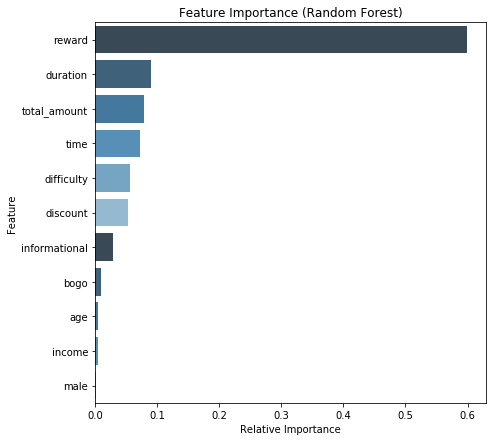

In [47]:
# Plot a bar chart to check the feature importance
relative_importance = RF_classifier.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(features.columns,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

plt.figure(figsize=(7, 7))
sns.barplot(x='relativeimportance',
            y='feature',
            palette = sns.color_palette("Blues_d"),
            data=feature_importance)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.show()

From the bar chart we can find out some prediction in this model
- Reward given for completing an offer is the most importance
- Discount offers are more attractive than BOGO offer
- Male customers react more frequently than female customer